## Locality-sensitive hashing

In this specific part of the homework we are asked to minhash encode the customers from the bank dataset and then build a LSH implementation exploiting the minhash encoding itself. These are the main sub-tasks that we need to complete:
- Build the _shingle matrix_. In order to perform minhashing we need to consider each observation as a finite set with the levels of its categorical features as its elements. It goes without saying that if we have numerical features we need to discretize them. This is basically one-hot encoding (+ discretization), and in this specific context the process is called _shingling_. The resulting _shingle matrix_ is a matrix with sets/customers on the column axis and one hot encoded representation of the features on the row axis.
- Perform the minhashing. We build a series of permutations of the order of the features in the row-axis of the _shingle matrix_, and for each permutation we get for each set/customer the index of the first non-zero entry. For each set/customer we thus get a minhash signature, built from retrieving the indexes. The set of the signatures is the _minhash matrix_.
- The LSH implementation itself. The _minhash matrix_ is partitioned along the permutation axis according to a chosen number of bands; if the signature of a customer/set in a band collides with the one of another, then the two customers are placed together in one bucket. It can be shown that the probability of minhash values colliding for one permutation is exactly equal to the Jaccard similarity between the sets/customers. As we increase the bandwidth (i.e. decrease the number of bands) the match is modelled by a Bernoulli random variable with a lower and lower mean: $p = [J(A,B)]^b$, with $b$ as the bandwidth and $J(A,B)$ as the Jaccard similarity between A and B. Therefore, with a strict enough choice of the bandwidth, only **very** similar observations/sets will have one or more of their bands in the _minhash matrix_ matching.

Our implementation of the whole process heavily relies on objected-oriented programming to have a tidier approach and to keep the overall pre-processing steps (from _shingling_ to minhashing) reproducible. All the functions and the classes are inside the _lsh\_bank_ package in the GitHub repository, and we will explore them step-by-step as we call them, but we will not go in-depth, since the code is available and well-commented.

First of all, we import everything that we need from the package.

In [15]:
from lsh_bank import Shingling, min_hashing, Shuffling, lsh_buckets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

First of all, we instantiate an object from the `Shingling` class; this is a class keeping as attributes the _scikit-learn_ objects used to transform the original dataset in its _shingle matrix_. This allows us to replicate the shingling process at query time, thus keeping the overall pipeline consistent.

The factory/constructor method for the `Shingling` class we are using here takes as input the table of the transactions to build the instance, taking into consideration all the necessary pre-processing steps. Specifically:

- Notice that since we have some transactions referring to the same customer, we first group by some features we consider as key (not just the customer ID, which we can see is not sufficient, but also their gender and date of birth) and perform appropriate summarization operations. For example, only the most recently recorded account balance is considered.
- A number of pre-processing steps for what concerns time data are performed, such as fixing the formats, replacing dates of birth from 1800 with missing values (then imputed with the mean); the age is computed for each customer and the hour of the transaction is extracted from the average transaction time.

As we have stressed, the discretization/the shingling itself is handled by _scikit_ objects (instances of [KBins Discretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) and [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)) in the `__init__` method, which also assigns the (sparse) _shingle matrix_ and the customer dataset to attributes of the object.

In [16]:
trans_table = pd.read_csv('bank_transactions.csv', index_col='TransactionID')
shingling_obj = Shingling.constructor(trans_table)

At this point, we need to perform the minhashing. First of all, we need to permute the shingle matrix, and we need to do that in a reliable way. Therefore, we define a `Shuffling` class which computes the permutations given a seed and holds the permutations as a NumPy array (i.e. the original indexes in a permuted order). The class has a `shuffle` instance method which is a generator function, returning at each iteration the array permuted through fancy indexing. We consider 400 permutations of the _shingle matrix_.

With the `min_hashing` function we then iterate over the permutations, and we use the `argmax` method of the NumPy array in order to get the first non-zero elements across the first axis, the one of the rows. The result is a row of indexes for each permutation, with the whole set of rows forming the so-called _signature matrix_.

Below the following code the first 10 rows and the first 10 columns of the _signature matrix_ are shown.

In [17]:
# The shuffling object is initialized with the number of features, the number of permutations and a seed
shuffling_obj = Shuffling(shingling_obj.shingle_matrix.shape[0], 400, 123456)
# The min_hashing function requires the shuffling object and the shingle matrix.
# Internally, the shingle matrix is passed to the generator method from the Shuffling object, which then at each iteration returns the permuted array
signatures_array = min_hashing(shuffling_obj, shingling_obj.shingle_matrix)

In [18]:
signatures_array[:10, :10]

array([[ 0,  9, 31,  0, 20, 24,  8, 25,  0,  4],
       [ 1, 14, 13,  1, 14,  4, 11, 14,  1, 24],
       [ 0,  5, 15,  0, 21,  2, 26, 34, 33, 35],
       [ 1, 39,  1,  1,  6,  8,  1, 10,  1,  1],
       [20, 18,  1,  0, 18,  4, 13, 18,  2, 21],
       [ 3,  7,  3,  3, 20, 31,  3, 18,  3,  3],
       [ 2,  6,  0,  0,  0, 17,  5, 13,  2,  5],
       [ 5, 35,  0,  0,  0,  2,  4, 11,  5,  5],
       [18, 21, 33, 52, 21,  5,  3, 11, 28, 32],
       [ 1,  0, 13,  2,  0, 17, 17, 18,  1, 13]], dtype=int32)

At this point we just need to call the function returning the dictionary containing the buckets, `lsh_buckets`. This function receives the signature matrix and the requested number of bands, thus partitioning the matrix accordingly. Each bucket has as key the minhash signature for the specific band **together with** an index to identify the band itself. The function also deals with the cases when the number of bands is not a divisor of the number of permutations (i.e. the length of a whole minhash signature): the first $length - length\;\mathrm{mod}\; {n\_bands}$ elements are considered for the split in evenly sized bands, with the remainder (of size $length\;\mathrm{mod}\;n\_bands$) considered as a separate band.

In order to choose the appropriate number of bands, we have to consider some probabilistic reasoning. Probabilistically speaking, for a given Jaccard similarity between A and B, $J(A,B)$ and with the number of bands set to $n$, the probability of having one or more matches (one matching band or more) is simply: $1-(1-J(A,B)^\frac{400}{n})^{n}$. This results in a function which can be plotted easily; we just consider the divisor of 400 to keep things simple.

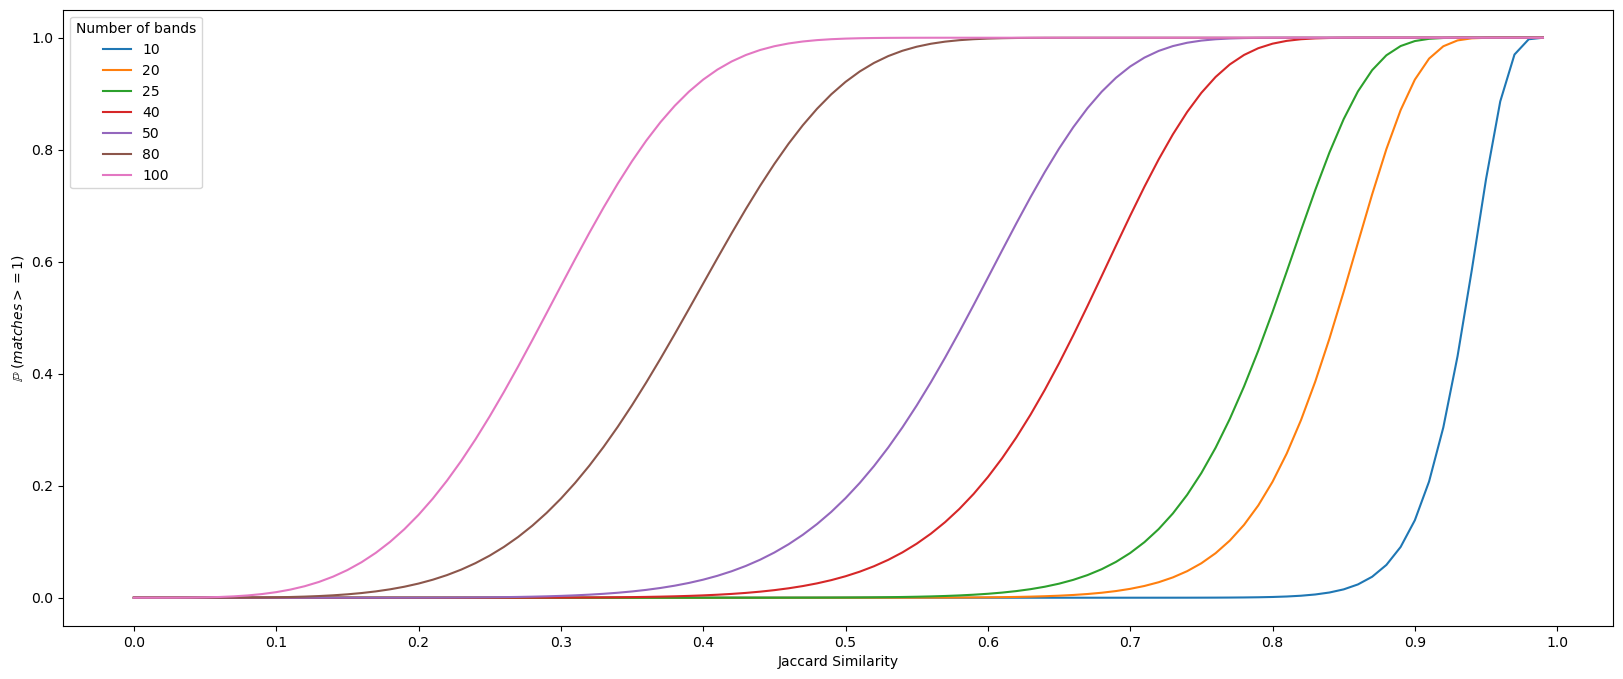

In [19]:
x = np.arange(0, 1, 0.01)
y = np.array([1-(1-x**(400/n))**n for n in [10, 20, 25, 40, 50, 80, 100]]).T
plt.figure().set_size_inches(20, 8)
plt.plot(x, y)
plt.legend(['10', '20', '25', '40', '50', '80', '100'], title = 'Number of bands')
plt.xlabel('Jaccard Similarity')
plt.xticks(np.arange(0, 1.01, 0.1))
plt.ylabel(r'$\mathbb{P}\;(matches>=1)$')
plt.show()

Since a set in this case can only hold up to 6 elements (we have discretized and each bin is an element, but bins from the same feature are exclusive); therefore, for 6, 5, 4, 3 elements in common, $J(A,B)$ is respectively equal to 1, 0.71, 0.5 and 0.33. In order to have sets with 5 elements in common matching in bands (one or more times) with $\mathbb{P}\approx 1$ we cannot consider a number of bands of 25 or lower, as we can see from the plot. Two good options seem to be 40 or 50, but 40 seems too strict, since for 5 elements in common (i.e. very similar customers/sets) we would have about 0.734 as the probability of one or more bands matching; with 50 the probability rises to about 0.964, which is what we need (a match almost certainly arises). We thus choose 50.

In [20]:
buckets = lsh_buckets(minhash_signatures_dataset=signatures_array, n_bands=50)

### Query time!

Now we just have to ingest the queries and return the most similar customers for each one of them. First of all, we need to pre-process the queries, which are each converted to their minhash signature. The way the pipeline was designed until now makes every step reproducible:
- The `Shingling` object hosts the scikit objects and the logic needed to replicate for a set of queries the transformation to the _shingle matrix_. This step is automated with the `transform` method.
- The `Shuffling` object hosts the array of permutations used to build the minhash signature matrix. Therefore, we can just call the `min_hashing` function with the same `Shuffling` object but with a different _shingle matrix_, the one coming from the _shingling_ of the queries.

Let's take a look at the first 10 rows of the query table (which has 50 rows).

In [21]:
query_array = pd.read_csv('query_users.csv')
query_array[:10]

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0
5,10/1/81,M,WORLD TRADE CENTRE BANGALORE,23143.95,11/9/16,192906,303.0
6,20/9/76,F,CHITTOOR,15397.80,28/8/16,92633,20.0
7,10/4/91,M,MOHALI,426.30,2/8/16,203754,50.0
8,19/3/90,M,MOHALI,4609.34,26/8/16,184015,300.0
9,19/12/70,M,SERAMPORE,6695988.46,27/8/16,144030,299.0


Now we can retrieve the output of the LSH algorithm for the given query observations.

In [30]:
import time

In [31]:
start = time.time()
query_array_transformed = shingling_obj.transform(query_array) # Transform the query array in a shingle matrix
query_array_signatures = min_hashing(shuffling_obj, query_array_transformed) # get signatures for each query
lsh_query_output = list() # Initialize list which will hold the DataFrames with the LSH output for each query
for cust in query_array_signatures.T: # iterate over columns of the signature matrix
    output_cust = list() # Initialize list of output for specific query/customer
    for idx_band, band in enumerate(np.split(cust, 50)): # get bucket from band index and values of the band
        output_cust.extend(buckets[tuple([idx_band]+band.tolist())]) # extend list of output with bucket content
    output_cust = Counter(output_cust) # count occurrences of elements in final list
    # append to main list the DataFrame with the matching customers (+ the number of matches)
    lsh_query_output.append(shingling_obj.costumer_table.iloc[list(output_cust.keys())].assign(
        matches = output_cust.values(), orig_index = list(output_cust.keys())))
time.time()-start

0.08367919921875

As we can see, the retrieval of the buckets for the queries is quite fast, it took about 83 ms.

Now, let's evaluate what we actually got. A good is idea is checking the actual number of elements in common that we are having between the query and the candidate customers we are getting as output (the similar ones). The average of the averages (because we are computing the average number of elements in common for a query, and then we are averaging for all the queries) is 3.84, which makes sense since, although it is true that for a specific observation $\mathbb{P(matches>=1)}$ is quite low if there are 4 elements in common, but 4 elements in common is a weaker condition to impose than having 5, so there will be far more observations satisfying it. The same holds for 3 elements in common. The (far) greater number of observations satisfying the condition counterbalances the lower probability; we cannot just sum the probabilities since the events **are not** disjoint, but the idea holds anyway.

In [36]:
in_common_mean = list()
# lsh query output is a list of DataFrame, each having as rows the similar observations for a single query
for idx_query, query_output in enumerate(lsh_query_output):
    slice_shingle = shingling_obj.shingle_matrix[:, query_output.orig_index].toarray()
    query_rep = query_array_transformed[:, idx_query].toarray()
    # The boolean expression is just a trick for the following
    # 0 and 0 = False |||| 1 and 1 = True |||| 0 and 1 = False
    # and then sum over booleans considers False as 0 and True as 1, since 1 is truthy and 0 is falsy
    in_common_mean.append(np.mean(np.sum(slice_shingle & query_rep, axis = 0)))

In [37]:
np.mean(in_common_mean)

3.84522792159735

Anyway, we can easily counter this problem (if we want to) by taking into consideration the amount of times a match happened; of course the higher the number of bands matching, the higher the chance that we are looking at a genuine similar observation. We have stored that information with a Counter object before, so we can easily use that. A naïve and relatively good way to do so would be to filter according to the mean number of matches for the query.

In [38]:
in_common_mean = list()
for idx_query, query_output in enumerate(lsh_query_output):
    slice_shingle = shingling_obj.shingle_matrix[:, query_output[query_output.matches >=
                                                                 np.mean(query_output.matches)].orig_index].toarray()
    query_rep = query_array_transformed[:, idx_query].toarray()
    in_common_mean.append(np.mean(np.sum(slice_shingle & query_rep, axis = 0)))

In [39]:
np.mean(in_common_mean)

4.644941940151624